In [ ]:
import pandas as pd

obesity_df = pd.read_csv('/content/sample_data/ObesityDataSet_raw_and_data_sinthetic.csv')

#observing the info of the file
obesity_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [ ]:
#Check how many NA values are in the table

obesity_df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

## Cleaning Data and preparing data

In [ ]:
import numpy as np


# Change Age as integers
obesity_df['Age'] = obesity_df['Age'].astype(int)

# Up to 2 decimal values
obesity_df = np.round(obesity_df, decimals=2)

# Renaming columns
obesity_df.rename(columns={'NObeyesdad':'y', 'family_history_with_overweight':'Overweight_family'},inplace=True)

# filtering categorical values and counting categories per column
idx = obesity_df.dtypes == 'object'
obesity_df.iloc[:, idx.values].nunique()

Gender               2
Overweight_family    2
FAVC                 2
CAEC                 4
SMOKE                2
SCC                  2
CALC                 4
MTRANS               5
y                    7
dtype: int64

## Encoding categorical values

For columns with 2 categories **Label encoding** will be used


For Columns with 4 categories **One-Hot encoding** will be used

For columns with 5 or more categories **Binary Encoding** will be used

In [ ]:
#change the columns to categorical
obesity_df.iloc[:, idx.values] = obesity_df.iloc[:, idx.values].astype('category')

### Label Encoding 

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

#Label encoding for columns with 2 categories
#finding the columns with only 2 categories and apply to each one labelencoder
idx = obesity_df.nunique() == 2
columns = obesity_df.iloc[:,idx.values].columns.tolist()
for c in columns:
  obesity_df[c] = labelencoder.fit_transform(obesity_df[c])



### One-shot encoding

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

# Finding the categorical columns with 4 values
idx = obesity_df.nunique() == 4
columns = obesity_df.iloc[:,idx.values].columns.tolist()
# one-hot each column and add it to the dataframe
for c in columns:
  lb_results = lb.fit_transform(obesity_df[c])
  lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

  # concatenating the one-hot columns
  obesity_df = pd.concat([obesity_df,lb_results_df], axis = 1)
  # Remove that column
  del obesity_df[c]

### Binary Encoding

In [ ]:
#before Binary encoding we need to elminate duplicate column names

cols=pd.Series(obesity_df.columns)

for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

# rename the columns with the cols list.
obesity_df.columns=cols

In [ ]:
!pip install category_encoders

import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['MTRANS'])
df_binary = encoder.fit_transform(obesity_df)

In [ ]:
df_binary=df_binary[[c for c in df_binary if c not in ['y']] + ['y']]

df_binary.head()

,Gender,Age,Height,Weight,Overweight_family,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,MTRANS_0,MTRANS_1,MTRANS_2,MTRANS_3,Always,Frequently,Sometimes,no,Always.1,Frequently.1,Sometimes.1,no.1,y
0,0,21,1.62,64.0,1,0,2.0,3.0,0,2.0,0,0.0,1.0,0,0,0,1,0,0,1,0,0,0,0,1,Normal_Weight
1,0,21,1.52,56.0,1,0,3.0,3.0,1,3.0,1,3.0,0.0,0,0,0,1,0,0,1,0,0,0,1,0,Normal_Weight
2,1,23,1.80,77.0,1,0,2.0,3.0,0,2.0,0,2.0,1.0,0,0,0,1,0,0,1,0,0,1,0,0,Normal_Weight
3,1,27,1.80,87.0,0,0,3.0,3.0,0,2.0,0,2.0,0.0,0,0,1,0,0,0,1,0,0,1,0,0,Overweight_Level_I
4,1,22,1.78,89.8,0,0,2.0,1.0,0,2.0,0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,1,0,Overweight_Level_II


## Training and testing data using scikit learn

[Text(0, 0, 'Insufficient_Weight'),
 Text(0, 0, 'Normal_Weight'),
 Text(0, 0, 'Obesity_Type_I'),
 Text(0, 0, 'Obesity_Type_II'),
 Text(0, 0, 'Obesity_Type_III'),
 Text(0, 0, 'Overweight_Level_I'),
 Text(0, 0, 'Overweight_Level_II')]

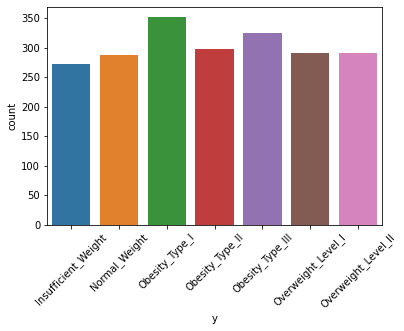

In [ ]:
# plot count of labels, to observe if classes are not balanced
import matplotlib.pyplot as plt
import seaborn as sns

chart = sns.countplot(x = 'y', data=df_binary)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [ ]:
# separating data and labels
X = df_binary.loc[:, df_binary.columns != 'y']
y = df_binary.loc[:, df_binary.columns == 'y']

# train model using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train = np.ravel(y_train)

logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Results

In [ ]:
from sklearn.metrics import classification_report
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.82      0.87      0.84        90
      Normal_Weight       0.73      0.69      0.71        87
     Obesity_Type_I       0.80      0.83      0.82       103
    Obesity_Type_II       0.92      1.00      0.96        90
   Obesity_Type_III       0.96      1.00      0.98       101
 Overweight_Level_I       0.78      0.70      0.74        81
Overweight_Level_II       0.70      0.62      0.66        82

           accuracy                           0.82       634
          macro avg       0.82      0.82      0.81       634
       weighted avg       0.82      0.82      0.82       634



In [ ]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82
